# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

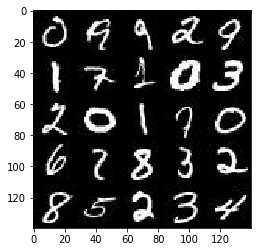

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

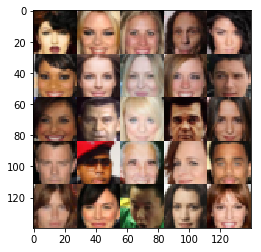

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    z_data = tf.placeholder(tf.float32, (None, z_dim), name='z_dim')
    learning_rate = tf.placeholder(tf.float32, None,  name='learning_rate')
    return (input_real, z_data, learning_rate)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [8]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        alpha = 0.2
        
        images = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * images, images)

        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)

        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3= tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        
        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*512))
        logits = tf.layers.dense(flat, 1)
        output = tf.sigmoid(logits) 
   

        return output,logits 


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [9]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse= not is_train):
        alpha = 0.2
        x1 = tf.layers.dense(z, 2*2*512)
        
        x1 = tf.reshape(x1, (-1, 2, 2, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)

    
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, 2, 'same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)   

        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        
        out = tf.tanh(logits)
        
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [10]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake

    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [11]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    gen_updates = [op for op in update_ops if op.name.startswith('generator')]
    
    with tf.control_dependencies(gen_updates):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [12]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [13]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model

    input_real, input_z, learn_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    
    saver = tf.train.Saver()    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                batch_images *= 2
                
                _ = sess.run(d_train_opt, feed_dict = {input_real: batch_images, input_z:batch_z, learn_rate: learning_rate})
                _ = sess.run(g_train_opt, feed_dict = {input_z : batch_z, learn_rate:learning_rate})
                                

                if steps % 10 == 0:    
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real:batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i, epoch_count),
                          "Discriinator Loss: {:.4f}".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 9, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 0/2... Discriinator Loss: 8.7313 Generator Loss: 0.0002
Epoch 0/2... Discriinator Loss: 0.0928 Generator Loss: 10.8969
Epoch 0/2... Discriinator Loss: 2.4045 Generator Loss: 0.1585
Epoch 0/2... Discriinator Loss: 0.2402 Generator Loss: 2.7560
Epoch 0/2... Discriinator Loss: 0.6978 Generator Loss: 1.3148
Epoch 0/2... Discriinator Loss: 0.2547 Generator Loss: 5.3139
Epoch 0/2... Discriinator Loss: 2.2411 Generator Loss: 0.1829
Epoch 0/2... Discriinator Loss: 1.2719 Generator Loss: 5.8644
Epoch 0/2... Discriinator Loss: 0.5696 Generator Loss: 10.7462
Epoch 0/2... Discriinator Loss: 0.1125 Generator Loss: 9.0806


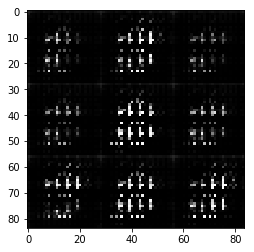

Epoch 0/2... Discriinator Loss: 0.0040 Generator Loss: 6.7730
Epoch 0/2... Discriinator Loss: 0.8970 Generator Loss: 0.8298
Epoch 0/2... Discriinator Loss: 0.1511 Generator Loss: 6.9315
Epoch 0/2... Discriinator Loss: 0.0980 Generator Loss: 3.3936
Epoch 0/2... Discriinator Loss: 0.1664 Generator Loss: 15.3368
Epoch 0/2... Discriinator Loss: 0.7746 Generator Loss: 8.7331
Epoch 0/2... Discriinator Loss: 0.1192 Generator Loss: 2.6683
Epoch 0/2... Discriinator Loss: 0.5162 Generator Loss: 1.3905
Epoch 0/2... Discriinator Loss: 2.0809 Generator Loss: 0.3799
Epoch 0/2... Discriinator Loss: 1.6297 Generator Loss: 0.6104


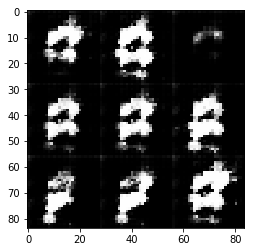

Epoch 0/2... Discriinator Loss: 0.2120 Generator Loss: 2.6122
Epoch 0/2... Discriinator Loss: 0.0758 Generator Loss: 4.0049
Epoch 0/2... Discriinator Loss: 0.7701 Generator Loss: 1.4056
Epoch 0/2... Discriinator Loss: 0.0628 Generator Loss: 4.0424
Epoch 0/2... Discriinator Loss: 0.0321 Generator Loss: 4.7979
Epoch 0/2... Discriinator Loss: 0.2518 Generator Loss: 2.8993
Epoch 0/2... Discriinator Loss: 1.0725 Generator Loss: 13.9407
Epoch 0/2... Discriinator Loss: 1.8618 Generator Loss: 8.1473
Epoch 0/2... Discriinator Loss: 2.4317 Generator Loss: 8.4616
Epoch 0/2... Discriinator Loss: 0.3515 Generator Loss: 2.5188


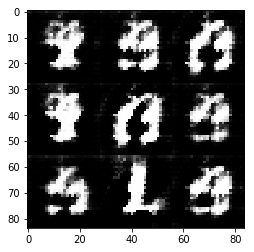

Epoch 0/2... Discriinator Loss: 0.7479 Generator Loss: 1.1693
Epoch 0/2... Discriinator Loss: 0.6698 Generator Loss: 4.0435
Epoch 0/2... Discriinator Loss: 0.1376 Generator Loss: 3.1524
Epoch 0/2... Discriinator Loss: 1.0539 Generator Loss: 7.3527
Epoch 0/2... Discriinator Loss: 0.3606 Generator Loss: 2.1629
Epoch 0/2... Discriinator Loss: 0.6133 Generator Loss: 1.8103
Epoch 0/2... Discriinator Loss: 0.3168 Generator Loss: 3.5556
Epoch 0/2... Discriinator Loss: 0.5181 Generator Loss: 1.8861
Epoch 0/2... Discriinator Loss: 0.3861 Generator Loss: 2.0848
Epoch 0/2... Discriinator Loss: 0.2665 Generator Loss: 2.6775


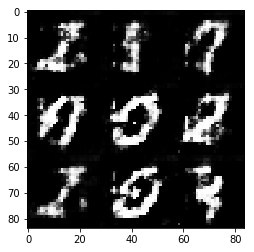

Epoch 0/2... Discriinator Loss: 0.5566 Generator Loss: 4.4920
Epoch 0/2... Discriinator Loss: 0.3484 Generator Loss: 1.9111
Epoch 0/2... Discriinator Loss: 0.5825 Generator Loss: 3.1762
Epoch 0/2... Discriinator Loss: 1.5781 Generator Loss: 6.2192
Epoch 0/2... Discriinator Loss: 0.6387 Generator Loss: 1.6377
Epoch 0/2... Discriinator Loss: 1.1861 Generator Loss: 0.5772
Epoch 0/2... Discriinator Loss: 0.3119 Generator Loss: 2.1329
Epoch 0/2... Discriinator Loss: 0.5204 Generator Loss: 2.0397
Epoch 0/2... Discriinator Loss: 0.9383 Generator Loss: 1.0614
Epoch 0/2... Discriinator Loss: 0.4262 Generator Loss: 2.6862


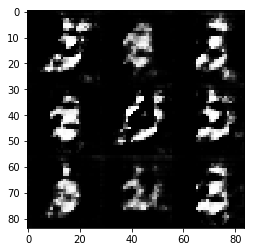

Epoch 0/2... Discriinator Loss: 0.7556 Generator Loss: 1.2815
Epoch 0/2... Discriinator Loss: 0.2756 Generator Loss: 2.6131
Epoch 0/2... Discriinator Loss: 0.3241 Generator Loss: 2.1159
Epoch 0/2... Discriinator Loss: 0.8153 Generator Loss: 2.8852
Epoch 0/2... Discriinator Loss: 0.7597 Generator Loss: 3.8238
Epoch 0/2... Discriinator Loss: 0.7778 Generator Loss: 0.9722
Epoch 0/2... Discriinator Loss: 0.4723 Generator Loss: 2.0434
Epoch 0/2... Discriinator Loss: 1.2033 Generator Loss: 0.8869
Epoch 0/2... Discriinator Loss: 0.5642 Generator Loss: 1.4342
Epoch 0/2... Discriinator Loss: 0.9235 Generator Loss: 1.0949


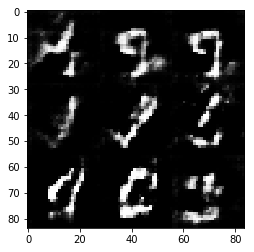

Epoch 0/2... Discriinator Loss: 1.3195 Generator Loss: 0.4481
Epoch 0/2... Discriinator Loss: 0.6223 Generator Loss: 1.2979
Epoch 0/2... Discriinator Loss: 0.9006 Generator Loss: 0.8699
Epoch 0/2... Discriinator Loss: 0.9939 Generator Loss: 0.7025
Epoch 0/2... Discriinator Loss: 0.5859 Generator Loss: 1.7549
Epoch 0/2... Discriinator Loss: 0.7880 Generator Loss: 0.9335
Epoch 0/2... Discriinator Loss: 0.5689 Generator Loss: 1.7681
Epoch 0/2... Discriinator Loss: 0.8538 Generator Loss: 0.9148
Epoch 0/2... Discriinator Loss: 1.8048 Generator Loss: 0.3053
Epoch 0/2... Discriinator Loss: 1.3801 Generator Loss: 2.9670


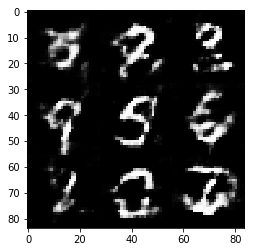

Epoch 0/2... Discriinator Loss: 1.0197 Generator Loss: 0.8673
Epoch 0/2... Discriinator Loss: 0.8889 Generator Loss: 1.5405
Epoch 0/2... Discriinator Loss: 1.0825 Generator Loss: 1.0210
Epoch 0/2... Discriinator Loss: 0.5231 Generator Loss: 2.4483
Epoch 0/2... Discriinator Loss: 1.0734 Generator Loss: 2.1774
Epoch 0/2... Discriinator Loss: 0.7125 Generator Loss: 1.1058
Epoch 0/2... Discriinator Loss: 0.9074 Generator Loss: 2.3485
Epoch 0/2... Discriinator Loss: 0.9141 Generator Loss: 0.7948
Epoch 0/2... Discriinator Loss: 0.7955 Generator Loss: 1.5082
Epoch 0/2... Discriinator Loss: 1.0106 Generator Loss: 2.8993


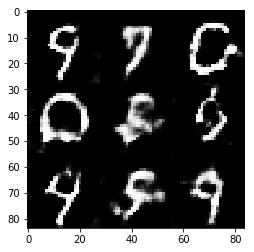

Epoch 0/2... Discriinator Loss: 0.6432 Generator Loss: 3.5053
Epoch 0/2... Discriinator Loss: 0.2708 Generator Loss: 3.2876
Epoch 0/2... Discriinator Loss: 0.6760 Generator Loss: 1.2310
Epoch 0/2... Discriinator Loss: 1.3425 Generator Loss: 0.6699
Epoch 0/2... Discriinator Loss: 0.7391 Generator Loss: 0.9669
Epoch 0/2... Discriinator Loss: 0.9602 Generator Loss: 3.2388
Epoch 0/2... Discriinator Loss: 0.8957 Generator Loss: 1.1146
Epoch 0/2... Discriinator Loss: 0.9336 Generator Loss: 2.3502
Epoch 0/2... Discriinator Loss: 0.5430 Generator Loss: 1.5923
Epoch 0/2... Discriinator Loss: 0.9445 Generator Loss: 0.8609


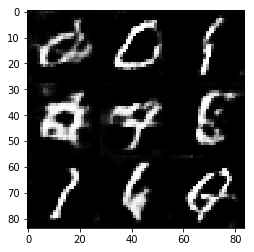

Epoch 0/2... Discriinator Loss: 0.9433 Generator Loss: 1.9690
Epoch 0/2... Discriinator Loss: 1.0644 Generator Loss: 0.7468
Epoch 0/2... Discriinator Loss: 0.6045 Generator Loss: 1.7587
Epoch 0/2... Discriinator Loss: 0.5832 Generator Loss: 1.6680
Epoch 0/2... Discriinator Loss: 1.1356 Generator Loss: 3.8799
Epoch 0/2... Discriinator Loss: 2.2415 Generator Loss: 0.1581
Epoch 0/2... Discriinator Loss: 0.6284 Generator Loss: 1.2911
Epoch 0/2... Discriinator Loss: 0.6180 Generator Loss: 1.3196
Epoch 0/2... Discriinator Loss: 0.8930 Generator Loss: 0.9151
Epoch 0/2... Discriinator Loss: 1.4561 Generator Loss: 0.3507


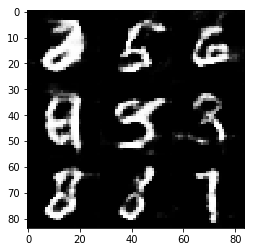

Epoch 0/2... Discriinator Loss: 0.4038 Generator Loss: 2.5210
Epoch 0/2... Discriinator Loss: 0.9762 Generator Loss: 0.8506
Epoch 0/2... Discriinator Loss: 1.7054 Generator Loss: 4.2587
Epoch 0/2... Discriinator Loss: 1.0973 Generator Loss: 2.7832
Epoch 0/2... Discriinator Loss: 0.5941 Generator Loss: 1.1990
Epoch 0/2... Discriinator Loss: 1.7643 Generator Loss: 0.2706
Epoch 0/2... Discriinator Loss: 1.2013 Generator Loss: 0.5488
Epoch 0/2... Discriinator Loss: 0.8130 Generator Loss: 1.0709
Epoch 0/2... Discriinator Loss: 1.9099 Generator Loss: 0.2432
Epoch 0/2... Discriinator Loss: 1.4107 Generator Loss: 0.3634


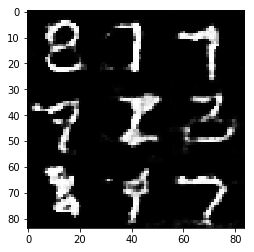

Epoch 0/2... Discriinator Loss: 0.9736 Generator Loss: 0.6143
Epoch 0/2... Discriinator Loss: 1.8392 Generator Loss: 0.2836
Epoch 0/2... Discriinator Loss: 1.6102 Generator Loss: 0.4301
Epoch 0/2... Discriinator Loss: 0.5514 Generator Loss: 1.6573
Epoch 0/2... Discriinator Loss: 0.7308 Generator Loss: 1.0572
Epoch 0/2... Discriinator Loss: 0.7757 Generator Loss: 2.6440
Epoch 0/2... Discriinator Loss: 0.8021 Generator Loss: 0.9258
Epoch 0/2... Discriinator Loss: 0.6339 Generator Loss: 2.6298
Epoch 0/2... Discriinator Loss: 0.9717 Generator Loss: 0.8894
Epoch 0/2... Discriinator Loss: 0.4976 Generator Loss: 1.3543


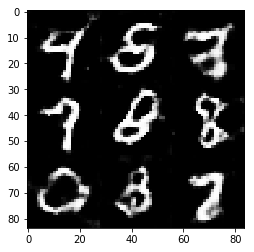

Epoch 1/2... Discriinator Loss: 0.7144 Generator Loss: 2.7617
Epoch 1/2... Discriinator Loss: 0.6368 Generator Loss: 1.5941
Epoch 1/2... Discriinator Loss: 1.3682 Generator Loss: 0.5090
Epoch 1/2... Discriinator Loss: 2.6100 Generator Loss: 0.1248
Epoch 1/2... Discriinator Loss: 0.9304 Generator Loss: 0.6890
Epoch 1/2... Discriinator Loss: 0.8450 Generator Loss: 0.8855
Epoch 1/2... Discriinator Loss: 0.7464 Generator Loss: 3.5688
Epoch 1/2... Discriinator Loss: 1.0388 Generator Loss: 0.6719
Epoch 1/2... Discriinator Loss: 1.0379 Generator Loss: 0.6813
Epoch 1/2... Discriinator Loss: 1.3932 Generator Loss: 0.4704


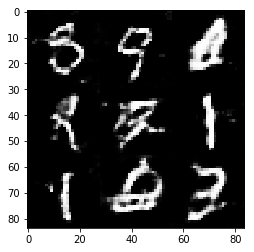

Epoch 1/2... Discriinator Loss: 1.2557 Generator Loss: 0.9471
Epoch 1/2... Discriinator Loss: 1.2174 Generator Loss: 0.5836
Epoch 1/2... Discriinator Loss: 1.0910 Generator Loss: 0.5436
Epoch 1/2... Discriinator Loss: 0.8560 Generator Loss: 0.7973
Epoch 1/2... Discriinator Loss: 1.0176 Generator Loss: 2.4689
Epoch 1/2... Discriinator Loss: 1.6435 Generator Loss: 0.3446
Epoch 1/2... Discriinator Loss: 1.0843 Generator Loss: 4.2008
Epoch 1/2... Discriinator Loss: 0.7210 Generator Loss: 1.7035
Epoch 1/2... Discriinator Loss: 1.0288 Generator Loss: 0.6151
Epoch 1/2... Discriinator Loss: 0.5072 Generator Loss: 2.1268


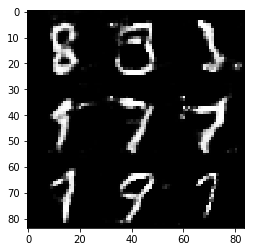

Epoch 1/2... Discriinator Loss: 1.2000 Generator Loss: 0.5268
Epoch 1/2... Discriinator Loss: 1.0749 Generator Loss: 0.6600
Epoch 1/2... Discriinator Loss: 3.1540 Generator Loss: 0.0824
Epoch 1/2... Discriinator Loss: 0.5737 Generator Loss: 1.4033
Epoch 1/2... Discriinator Loss: 1.1870 Generator Loss: 0.4897
Epoch 1/2... Discriinator Loss: 1.0407 Generator Loss: 2.5803
Epoch 1/2... Discriinator Loss: 0.7710 Generator Loss: 0.9817
Epoch 1/2... Discriinator Loss: 1.0376 Generator Loss: 0.5760
Epoch 1/2... Discriinator Loss: 1.4943 Generator Loss: 0.4091
Epoch 1/2... Discriinator Loss: 1.0456 Generator Loss: 3.3886


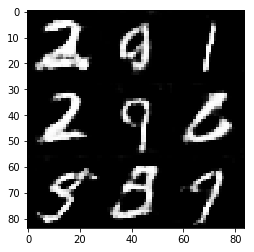

Epoch 1/2... Discriinator Loss: 0.6582 Generator Loss: 1.8635
Epoch 1/2... Discriinator Loss: 0.8948 Generator Loss: 0.8712
Epoch 1/2... Discriinator Loss: 0.8181 Generator Loss: 3.1701
Epoch 1/2... Discriinator Loss: 1.1025 Generator Loss: 0.5525
Epoch 1/2... Discriinator Loss: 1.6871 Generator Loss: 0.3366
Epoch 1/2... Discriinator Loss: 1.5861 Generator Loss: 0.3697
Epoch 1/2... Discriinator Loss: 1.8657 Generator Loss: 0.3715
Epoch 1/2... Discriinator Loss: 0.8263 Generator Loss: 0.8965
Epoch 1/2... Discriinator Loss: 0.8795 Generator Loss: 0.7888
Epoch 1/2... Discriinator Loss: 1.6161 Generator Loss: 0.2998


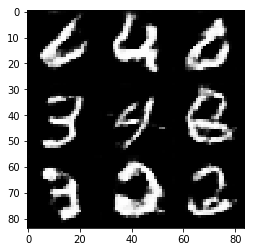

Epoch 1/2... Discriinator Loss: 1.5143 Generator Loss: 0.4130
Epoch 1/2... Discriinator Loss: 0.8724 Generator Loss: 1.8564
Epoch 1/2... Discriinator Loss: 1.0111 Generator Loss: 0.7466
Epoch 1/2... Discriinator Loss: 1.1291 Generator Loss: 0.6001
Epoch 1/2... Discriinator Loss: 1.0601 Generator Loss: 0.7204
Epoch 1/2... Discriinator Loss: 1.3331 Generator Loss: 0.4344
Epoch 1/2... Discriinator Loss: 2.0084 Generator Loss: 0.2409
Epoch 1/2... Discriinator Loss: 1.9672 Generator Loss: 0.3694
Epoch 1/2... Discriinator Loss: 0.8570 Generator Loss: 0.8553
Epoch 1/2... Discriinator Loss: 1.4398 Generator Loss: 0.3937


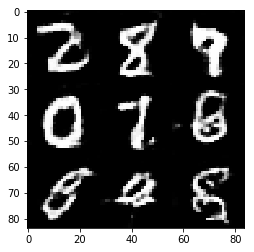

Epoch 1/2... Discriinator Loss: 0.5932 Generator Loss: 1.6042
Epoch 1/2... Discriinator Loss: 0.5658 Generator Loss: 1.7334
Epoch 1/2... Discriinator Loss: 1.0636 Generator Loss: 0.6840
Epoch 1/2... Discriinator Loss: 0.6863 Generator Loss: 0.9817
Epoch 1/2... Discriinator Loss: 0.7355 Generator Loss: 1.9100
Epoch 1/2... Discriinator Loss: 0.9702 Generator Loss: 0.7391
Epoch 1/2... Discriinator Loss: 0.8753 Generator Loss: 0.8422
Epoch 1/2... Discriinator Loss: 1.5482 Generator Loss: 0.4706
Epoch 1/2... Discriinator Loss: 1.8165 Generator Loss: 4.4432
Epoch 1/2... Discriinator Loss: 1.6336 Generator Loss: 0.2887


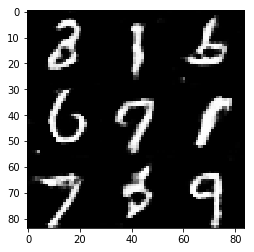

Epoch 1/2... Discriinator Loss: 0.7140 Generator Loss: 1.3525
Epoch 1/2... Discriinator Loss: 1.4224 Generator Loss: 0.3919
Epoch 1/2... Discriinator Loss: 0.9739 Generator Loss: 3.7073
Epoch 1/2... Discriinator Loss: 1.2798 Generator Loss: 0.5730
Epoch 1/2... Discriinator Loss: 1.1582 Generator Loss: 0.5205
Epoch 1/2... Discriinator Loss: 0.9654 Generator Loss: 3.9399
Epoch 1/2... Discriinator Loss: 1.4486 Generator Loss: 0.3707
Epoch 1/2... Discriinator Loss: 1.3197 Generator Loss: 0.4724
Epoch 1/2... Discriinator Loss: 1.1374 Generator Loss: 4.9338
Epoch 1/2... Discriinator Loss: 1.0477 Generator Loss: 2.7495


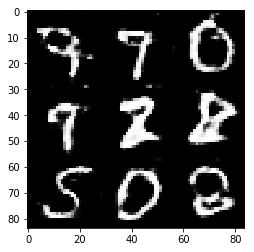

Epoch 1/2... Discriinator Loss: 2.1221 Generator Loss: 0.2092
Epoch 1/2... Discriinator Loss: 0.9034 Generator Loss: 1.1066
Epoch 1/2... Discriinator Loss: 0.6078 Generator Loss: 1.0787
Epoch 1/2... Discriinator Loss: 0.4875 Generator Loss: 1.3607
Epoch 1/2... Discriinator Loss: 2.7815 Generator Loss: 0.1198
Epoch 1/2... Discriinator Loss: 0.9847 Generator Loss: 0.7272
Epoch 1/2... Discriinator Loss: 1.8734 Generator Loss: 0.2292
Epoch 1/2... Discriinator Loss: 4.2362 Generator Loss: 0.0388
Epoch 1/2... Discriinator Loss: 1.6282 Generator Loss: 0.4426
Epoch 1/2... Discriinator Loss: 0.8595 Generator Loss: 0.8392


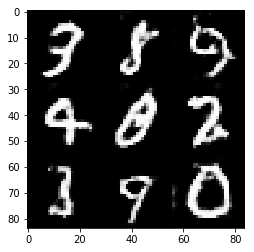

Epoch 1/2... Discriinator Loss: 0.6736 Generator Loss: 0.9897
Epoch 1/2... Discriinator Loss: 0.5643 Generator Loss: 2.0646
Epoch 1/2... Discriinator Loss: 0.5584 Generator Loss: 1.3874
Epoch 1/2... Discriinator Loss: 0.5602 Generator Loss: 1.5893
Epoch 1/2... Discriinator Loss: 1.1208 Generator Loss: 0.6520
Epoch 1/2... Discriinator Loss: 1.1259 Generator Loss: 0.7467
Epoch 1/2... Discriinator Loss: 0.7628 Generator Loss: 1.0171
Epoch 1/2... Discriinator Loss: 0.6206 Generator Loss: 1.4600
Epoch 1/2... Discriinator Loss: 0.7586 Generator Loss: 1.0280
Epoch 1/2... Discriinator Loss: 1.2298 Generator Loss: 0.5067


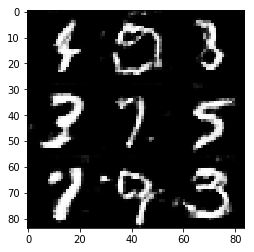

Epoch 1/2... Discriinator Loss: 1.5466 Generator Loss: 0.4870
Epoch 1/2... Discriinator Loss: 1.9143 Generator Loss: 0.2601
Epoch 1/2... Discriinator Loss: 2.5362 Generator Loss: 0.1393
Epoch 1/2... Discriinator Loss: 3.3424 Generator Loss: 7.7981
Epoch 1/2... Discriinator Loss: 0.6280 Generator Loss: 1.2294
Epoch 1/2... Discriinator Loss: 0.7345 Generator Loss: 1.1580
Epoch 1/2... Discriinator Loss: 1.0145 Generator Loss: 0.7046
Epoch 1/2... Discriinator Loss: 0.8276 Generator Loss: 0.9027
Epoch 1/2... Discriinator Loss: 0.7275 Generator Loss: 0.7994
Epoch 1/2... Discriinator Loss: 1.4081 Generator Loss: 0.4976


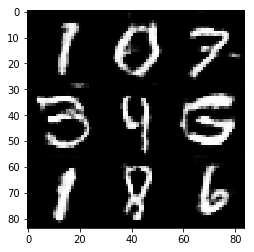

Epoch 1/2... Discriinator Loss: 0.4596 Generator Loss: 1.5839
Epoch 1/2... Discriinator Loss: 1.4441 Generator Loss: 0.4131
Epoch 1/2... Discriinator Loss: 1.8320 Generator Loss: 0.2545
Epoch 1/2... Discriinator Loss: 0.7625 Generator Loss: 1.1777
Epoch 1/2... Discriinator Loss: 0.4647 Generator Loss: 1.6442
Epoch 1/2... Discriinator Loss: 0.6810 Generator Loss: 1.1287
Epoch 1/2... Discriinator Loss: 1.2086 Generator Loss: 0.5635
Epoch 1/2... Discriinator Loss: 0.7894 Generator Loss: 3.5477
Epoch 1/2... Discriinator Loss: 1.0376 Generator Loss: 0.7797
Epoch 1/2... Discriinator Loss: 0.6958 Generator Loss: 1.1367


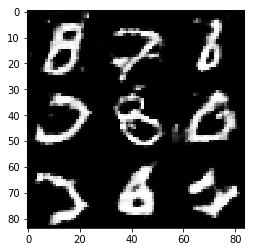

Epoch 1/2... Discriinator Loss: 1.1203 Generator Loss: 0.6859
Epoch 1/2... Discriinator Loss: 0.4576 Generator Loss: 1.6595
Epoch 1/2... Discriinator Loss: 1.7551 Generator Loss: 0.3948
Epoch 1/2... Discriinator Loss: 0.4549 Generator Loss: 2.0822
Epoch 1/2... Discriinator Loss: 1.3519 Generator Loss: 0.4569
Epoch 1/2... Discriinator Loss: 1.2477 Generator Loss: 0.6378
Epoch 1/2... Discriinator Loss: 1.0134 Generator Loss: 0.6994
Epoch 1/2... Discriinator Loss: 1.1280 Generator Loss: 0.7475
Epoch 1/2... Discriinator Loss: 1.7394 Generator Loss: 0.2604
Epoch 1/2... Discriinator Loss: 1.8076 Generator Loss: 0.2777


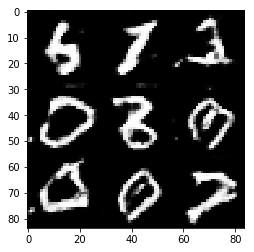

In [14]:
batch_size = 50
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 0/1... Discriinator Loss: 1.0081 Generator Loss: 18.9972
Epoch 0/1... Discriinator Loss: 7.2718 Generator Loss: 21.8500
Epoch 0/1... Discriinator Loss: 0.3741 Generator Loss: 2.2477
Epoch 0/1... Discriinator Loss: 0.8683 Generator Loss: 2.2472
Epoch 0/1... Discriinator Loss: 1.0049 Generator Loss: 1.4174
Epoch 0/1... Discriinator Loss: 9.7958 Generator Loss: 16.2189
Epoch 0/1... Discriinator Loss: 3.0687 Generator Loss: 0.2883
Epoch 0/1... Discriinator Loss: 1.8384 Generator Loss: 0.6268
Epoch 0/1... Discriinator Loss: 0.0580 Generator Loss: 3.4702
Epoch 0/1... Discriinator Loss: 0.0684 Generator Loss: 5.3024


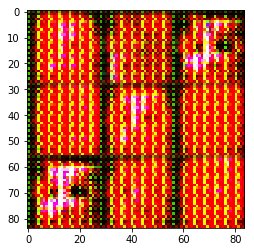

Epoch 0/1... Discriinator Loss: 0.1479 Generator Loss: 3.2416
Epoch 0/1... Discriinator Loss: 0.0856 Generator Loss: 3.5948
Epoch 0/1... Discriinator Loss: 0.0430 Generator Loss: 5.1598
Epoch 0/1... Discriinator Loss: 0.7486 Generator Loss: 1.0129
Epoch 0/1... Discriinator Loss: 0.0057 Generator Loss: 6.7011
Epoch 0/1... Discriinator Loss: 0.2446 Generator Loss: 4.7823
Epoch 0/1... Discriinator Loss: 0.0040 Generator Loss: 12.9565
Epoch 0/1... Discriinator Loss: 0.0487 Generator Loss: 4.0047
Epoch 0/1... Discriinator Loss: 0.0607 Generator Loss: 3.2840
Epoch 0/1... Discriinator Loss: 0.2476 Generator Loss: 2.2713


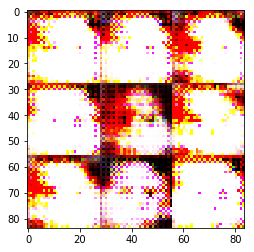

Epoch 0/1... Discriinator Loss: 0.3108 Generator Loss: 13.1115
Epoch 0/1... Discriinator Loss: 0.0536 Generator Loss: 3.7280
Epoch 0/1... Discriinator Loss: 0.0435 Generator Loss: 3.7677
Epoch 0/1... Discriinator Loss: 0.0043 Generator Loss: 6.8367
Epoch 0/1... Discriinator Loss: 0.0043 Generator Loss: 8.6223
Epoch 0/1... Discriinator Loss: 0.0029 Generator Loss: 15.9323
Epoch 0/1... Discriinator Loss: 0.2047 Generator Loss: 2.2124
Epoch 0/1... Discriinator Loss: 0.0146 Generator Loss: 5.6373
Epoch 0/1... Discriinator Loss: 0.6396 Generator Loss: 3.6217
Epoch 0/1... Discriinator Loss: 1.1974 Generator Loss: 4.5829


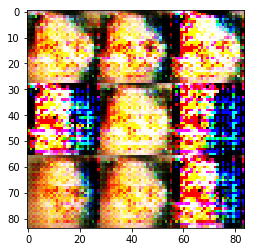

Epoch 0/1... Discriinator Loss: 0.8110 Generator Loss: 2.1334
Epoch 0/1... Discriinator Loss: 0.5955 Generator Loss: 3.6337
Epoch 0/1... Discriinator Loss: 0.8986 Generator Loss: 2.1233
Epoch 0/1... Discriinator Loss: 0.1586 Generator Loss: 2.4698
Epoch 0/1... Discriinator Loss: 0.3607 Generator Loss: 3.2111
Epoch 0/1... Discriinator Loss: 0.5450 Generator Loss: 1.4701
Epoch 0/1... Discriinator Loss: 0.0887 Generator Loss: 6.5871
Epoch 0/1... Discriinator Loss: 0.1446 Generator Loss: 3.2772
Epoch 0/1... Discriinator Loss: 0.1202 Generator Loss: 4.1702
Epoch 0/1... Discriinator Loss: 0.0899 Generator Loss: 4.2384


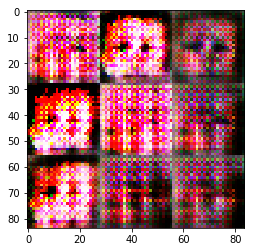

Epoch 0/1... Discriinator Loss: 0.0437 Generator Loss: 4.5124
Epoch 0/1... Discriinator Loss: 0.6985 Generator Loss: 1.4697
Epoch 0/1... Discriinator Loss: 5.2860 Generator Loss: 3.1790
Epoch 0/1... Discriinator Loss: 0.6191 Generator Loss: 1.5334
Epoch 0/1... Discriinator Loss: 3.2293 Generator Loss: 0.0997
Epoch 0/1... Discriinator Loss: 0.1900 Generator Loss: 3.3422
Epoch 0/1... Discriinator Loss: 0.0986 Generator Loss: 2.8496
Epoch 0/1... Discriinator Loss: 0.6292 Generator Loss: 1.3669
Epoch 0/1... Discriinator Loss: 1.6357 Generator Loss: 0.2899
Epoch 0/1... Discriinator Loss: 1.3634 Generator Loss: 0.7373


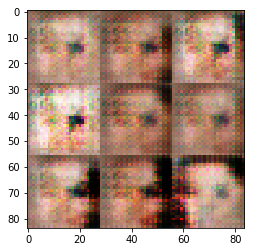

Epoch 0/1... Discriinator Loss: 1.4193 Generator Loss: 3.2001
Epoch 0/1... Discriinator Loss: 1.4016 Generator Loss: 0.6441
Epoch 0/1... Discriinator Loss: 0.9572 Generator Loss: 1.1178
Epoch 0/1... Discriinator Loss: 6.4321 Generator Loss: 6.5733
Epoch 0/1... Discriinator Loss: 1.6958 Generator Loss: 1.0734
Epoch 0/1... Discriinator Loss: 0.5430 Generator Loss: 1.8882
Epoch 0/1... Discriinator Loss: 0.4517 Generator Loss: 1.6182
Epoch 0/1... Discriinator Loss: 1.0001 Generator Loss: 0.6755
Epoch 0/1... Discriinator Loss: 0.1605 Generator Loss: 4.4296
Epoch 0/1... Discriinator Loss: 0.8247 Generator Loss: 1.0466


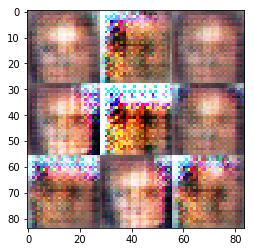

Epoch 0/1... Discriinator Loss: 0.6689 Generator Loss: 1.4536
Epoch 0/1... Discriinator Loss: 0.7882 Generator Loss: 1.7017
Epoch 0/1... Discriinator Loss: 1.0598 Generator Loss: 2.2496
Epoch 0/1... Discriinator Loss: 0.7389 Generator Loss: 3.0597
Epoch 0/1... Discriinator Loss: 0.9022 Generator Loss: 2.1933
Epoch 0/1... Discriinator Loss: 0.9963 Generator Loss: 2.0751
Epoch 0/1... Discriinator Loss: 1.2500 Generator Loss: 3.5002
Epoch 0/1... Discriinator Loss: 0.8225 Generator Loss: 2.0531
Epoch 0/1... Discriinator Loss: 0.1705 Generator Loss: 3.7995
Epoch 0/1... Discriinator Loss: 1.0080 Generator Loss: 0.8116


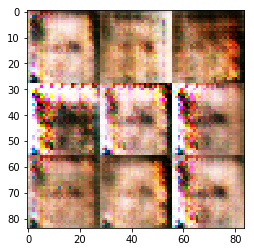

Epoch 0/1... Discriinator Loss: 0.2911 Generator Loss: 2.7343
Epoch 0/1... Discriinator Loss: 2.2325 Generator Loss: 3.9624
Epoch 0/1... Discriinator Loss: 1.0607 Generator Loss: 0.9974
Epoch 0/1... Discriinator Loss: 0.7976 Generator Loss: 1.7023
Epoch 0/1... Discriinator Loss: 1.1924 Generator Loss: 2.7526
Epoch 0/1... Discriinator Loss: 0.5524 Generator Loss: 1.3682
Epoch 0/1... Discriinator Loss: 1.0647 Generator Loss: 0.8827
Epoch 0/1... Discriinator Loss: 1.2350 Generator Loss: 0.7024
Epoch 0/1... Discriinator Loss: 1.2532 Generator Loss: 3.9483
Epoch 0/1... Discriinator Loss: 0.8272 Generator Loss: 0.8924


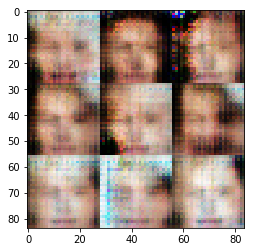

Epoch 0/1... Discriinator Loss: 1.1048 Generator Loss: 1.0875
Epoch 0/1... Discriinator Loss: 1.3251 Generator Loss: 0.4224
Epoch 0/1... Discriinator Loss: 0.7637 Generator Loss: 1.5360
Epoch 0/1... Discriinator Loss: 0.9718 Generator Loss: 1.1113
Epoch 0/1... Discriinator Loss: 0.7686 Generator Loss: 1.3035
Epoch 0/1... Discriinator Loss: 0.6234 Generator Loss: 1.2208
Epoch 0/1... Discriinator Loss: 0.3969 Generator Loss: 1.9335
Epoch 0/1... Discriinator Loss: 0.8138 Generator Loss: 1.1111
Epoch 0/1... Discriinator Loss: 0.9116 Generator Loss: 2.0768
Epoch 0/1... Discriinator Loss: 0.7923 Generator Loss: 2.2514


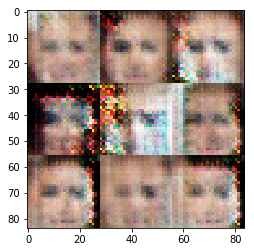

Epoch 0/1... Discriinator Loss: 0.6143 Generator Loss: 1.5692
Epoch 0/1... Discriinator Loss: 1.3270 Generator Loss: 0.4939
Epoch 0/1... Discriinator Loss: 1.0380 Generator Loss: 2.2121
Epoch 0/1... Discriinator Loss: 1.3046 Generator Loss: 0.5734
Epoch 0/1... Discriinator Loss: 1.1731 Generator Loss: 1.0954
Epoch 0/1... Discriinator Loss: 1.3072 Generator Loss: 1.3351
Epoch 0/1... Discriinator Loss: 1.3626 Generator Loss: 0.8522
Epoch 0/1... Discriinator Loss: 1.1076 Generator Loss: 1.7798
Epoch 0/1... Discriinator Loss: 1.7392 Generator Loss: 0.5710
Epoch 0/1... Discriinator Loss: 0.7495 Generator Loss: 1.1972


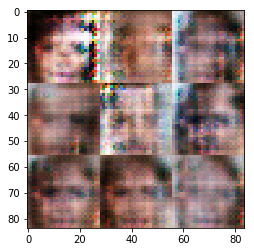

Epoch 0/1... Discriinator Loss: 0.7428 Generator Loss: 1.1618
Epoch 0/1... Discriinator Loss: 0.9276 Generator Loss: 0.9827
Epoch 0/1... Discriinator Loss: 0.8385 Generator Loss: 1.0187
Epoch 0/1... Discriinator Loss: 1.5269 Generator Loss: 2.8941
Epoch 0/1... Discriinator Loss: 1.1330 Generator Loss: 2.0578
Epoch 0/1... Discriinator Loss: 0.9733 Generator Loss: 0.9224
Epoch 0/1... Discriinator Loss: 0.8889 Generator Loss: 0.8250
Epoch 0/1... Discriinator Loss: 1.0958 Generator Loss: 0.9959
Epoch 0/1... Discriinator Loss: 2.4621 Generator Loss: 3.4182
Epoch 0/1... Discriinator Loss: 1.1227 Generator Loss: 1.7383


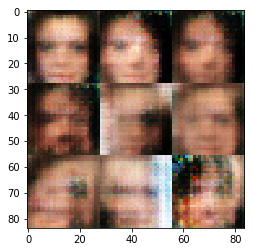

Epoch 0/1... Discriinator Loss: 0.7352 Generator Loss: 1.6615
Epoch 0/1... Discriinator Loss: 0.5496 Generator Loss: 1.3125
Epoch 0/1... Discriinator Loss: 1.0895 Generator Loss: 2.5369
Epoch 0/1... Discriinator Loss: 0.9510 Generator Loss: 1.4629
Epoch 0/1... Discriinator Loss: 0.8835 Generator Loss: 1.1792
Epoch 0/1... Discriinator Loss: 0.7172 Generator Loss: 1.4305
Epoch 0/1... Discriinator Loss: 0.7317 Generator Loss: 1.3691
Epoch 0/1... Discriinator Loss: 0.6644 Generator Loss: 2.1568
Epoch 0/1... Discriinator Loss: 1.6532 Generator Loss: 0.3749
Epoch 0/1... Discriinator Loss: 1.0544 Generator Loss: 1.2053


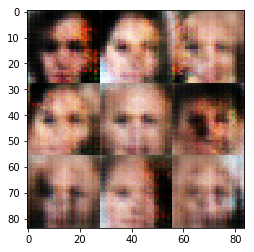

Epoch 0/1... Discriinator Loss: 0.8910 Generator Loss: 0.9987
Epoch 0/1... Discriinator Loss: 0.9428 Generator Loss: 2.1972
Epoch 0/1... Discriinator Loss: 0.9046 Generator Loss: 1.2214
Epoch 0/1... Discriinator Loss: 1.1399 Generator Loss: 0.7729
Epoch 0/1... Discriinator Loss: 1.1879 Generator Loss: 3.0531
Epoch 0/1... Discriinator Loss: 1.0721 Generator Loss: 0.6719
Epoch 0/1... Discriinator Loss: 0.7688 Generator Loss: 1.2244
Epoch 0/1... Discriinator Loss: 1.6767 Generator Loss: 3.0069
Epoch 0/1... Discriinator Loss: 0.4163 Generator Loss: 1.6929
Epoch 0/1... Discriinator Loss: 0.9482 Generator Loss: 0.9642


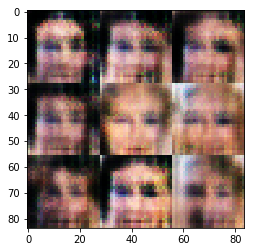

Epoch 0/1... Discriinator Loss: 1.2733 Generator Loss: 0.6281
Epoch 0/1... Discriinator Loss: 0.8261 Generator Loss: 1.1260
Epoch 0/1... Discriinator Loss: 0.7968 Generator Loss: 1.0896
Epoch 0/1... Discriinator Loss: 1.4369 Generator Loss: 0.4507
Epoch 0/1... Discriinator Loss: 0.8354 Generator Loss: 1.0377
Epoch 0/1... Discriinator Loss: 0.5465 Generator Loss: 1.4041
Epoch 0/1... Discriinator Loss: 1.3683 Generator Loss: 1.6172
Epoch 0/1... Discriinator Loss: 1.2439 Generator Loss: 1.4874
Epoch 0/1... Discriinator Loss: 0.5695 Generator Loss: 2.4286
Epoch 0/1... Discriinator Loss: 1.0208 Generator Loss: 0.9381


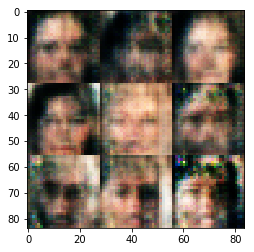

Epoch 0/1... Discriinator Loss: 0.9698 Generator Loss: 1.3535
Epoch 0/1... Discriinator Loss: 0.8521 Generator Loss: 1.5201
Epoch 0/1... Discriinator Loss: 0.6017 Generator Loss: 1.4240
Epoch 0/1... Discriinator Loss: 0.9411 Generator Loss: 1.6177
Epoch 0/1... Discriinator Loss: 0.6635 Generator Loss: 1.5827
Epoch 0/1... Discriinator Loss: 1.2329 Generator Loss: 0.8928
Epoch 0/1... Discriinator Loss: 0.8480 Generator Loss: 1.3594
Epoch 0/1... Discriinator Loss: 1.3355 Generator Loss: 0.5333
Epoch 0/1... Discriinator Loss: 0.9013 Generator Loss: 1.1550
Epoch 0/1... Discriinator Loss: 0.4928 Generator Loss: 1.8468


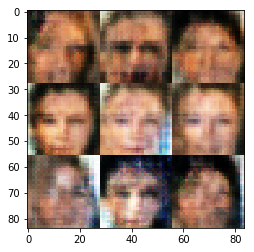

Epoch 0/1... Discriinator Loss: 0.7426 Generator Loss: 1.0319
Epoch 0/1... Discriinator Loss: 1.0302 Generator Loss: 1.1325
Epoch 0/1... Discriinator Loss: 0.7023 Generator Loss: 1.5017
Epoch 0/1... Discriinator Loss: 0.9779 Generator Loss: 0.7468
Epoch 0/1... Discriinator Loss: 1.3398 Generator Loss: 0.5436
Epoch 0/1... Discriinator Loss: 1.2020 Generator Loss: 1.2034
Epoch 0/1... Discriinator Loss: 1.9317 Generator Loss: 3.2324
Epoch 0/1... Discriinator Loss: 0.8266 Generator Loss: 0.9331
Epoch 0/1... Discriinator Loss: 0.8441 Generator Loss: 0.9926
Epoch 0/1... Discriinator Loss: 1.0344 Generator Loss: 0.7567


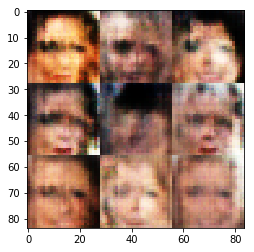

Epoch 0/1... Discriinator Loss: 1.0650 Generator Loss: 0.6772
Epoch 0/1... Discriinator Loss: 1.2437 Generator Loss: 0.7300
Epoch 0/1... Discriinator Loss: 1.0724 Generator Loss: 1.3344
Epoch 0/1... Discriinator Loss: 0.7016 Generator Loss: 1.1704
Epoch 0/1... Discriinator Loss: 1.1336 Generator Loss: 0.6230
Epoch 0/1... Discriinator Loss: 1.2763 Generator Loss: 0.4933
Epoch 0/1... Discriinator Loss: 1.0681 Generator Loss: 1.1100
Epoch 0/1... Discriinator Loss: 1.6963 Generator Loss: 0.4049
Epoch 0/1... Discriinator Loss: 2.5330 Generator Loss: 3.5094
Epoch 0/1... Discriinator Loss: 1.0695 Generator Loss: 1.0262


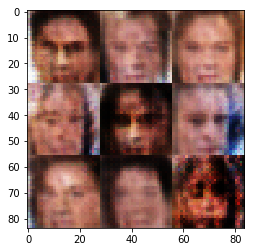

Epoch 0/1... Discriinator Loss: 1.0065 Generator Loss: 1.4550
Epoch 0/1... Discriinator Loss: 1.2449 Generator Loss: 0.6335
Epoch 0/1... Discriinator Loss: 1.0679 Generator Loss: 0.6680
Epoch 0/1... Discriinator Loss: 2.3794 Generator Loss: 2.9409
Epoch 0/1... Discriinator Loss: 0.8459 Generator Loss: 1.2907
Epoch 0/1... Discriinator Loss: 0.8009 Generator Loss: 1.1246
Epoch 0/1... Discriinator Loss: 1.0700 Generator Loss: 0.7671
Epoch 0/1... Discriinator Loss: 0.7817 Generator Loss: 1.0149
Epoch 0/1... Discriinator Loss: 1.1445 Generator Loss: 0.7629
Epoch 0/1... Discriinator Loss: 0.8500 Generator Loss: 0.7393


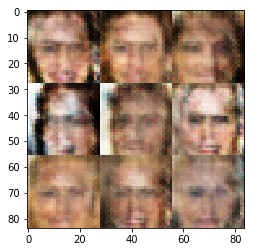

Epoch 0/1... Discriinator Loss: 0.6530 Generator Loss: 1.1830
Epoch 0/1... Discriinator Loss: 0.9952 Generator Loss: 1.1071
Epoch 0/1... Discriinator Loss: 1.0504 Generator Loss: 0.8165
Epoch 0/1... Discriinator Loss: 0.7532 Generator Loss: 1.4164
Epoch 0/1... Discriinator Loss: 1.1388 Generator Loss: 1.2694
Epoch 0/1... Discriinator Loss: 0.8084 Generator Loss: 1.2085
Epoch 0/1... Discriinator Loss: 0.4368 Generator Loss: 1.4593
Epoch 0/1... Discriinator Loss: 0.8455 Generator Loss: 1.7478
Epoch 0/1... Discriinator Loss: 1.0363 Generator Loss: 0.9588
Epoch 0/1... Discriinator Loss: 1.4774 Generator Loss: 0.3870


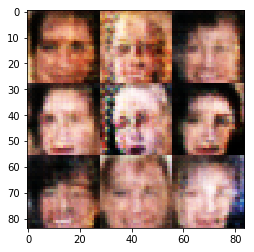

Epoch 0/1... Discriinator Loss: 1.1064 Generator Loss: 1.8760
Epoch 0/1... Discriinator Loss: 1.5451 Generator Loss: 0.5164
Epoch 0/1... Discriinator Loss: 1.0189 Generator Loss: 0.6761
Epoch 0/1... Discriinator Loss: 1.2630 Generator Loss: 2.4453
Epoch 0/1... Discriinator Loss: 1.0174 Generator Loss: 0.9379
Epoch 0/1... Discriinator Loss: 1.2072 Generator Loss: 0.6897
Epoch 0/1... Discriinator Loss: 1.5960 Generator Loss: 0.3482
Epoch 0/1... Discriinator Loss: 0.9006 Generator Loss: 0.7975
Epoch 0/1... Discriinator Loss: 0.9456 Generator Loss: 0.8744
Epoch 0/1... Discriinator Loss: 1.4302 Generator Loss: 2.8327


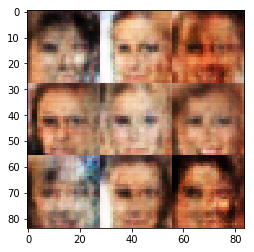

Epoch 0/1... Discriinator Loss: 1.1390 Generator Loss: 0.6181
Epoch 0/1... Discriinator Loss: 1.0884 Generator Loss: 0.8199
Epoch 0/1... Discriinator Loss: 0.9984 Generator Loss: 1.3701
Epoch 0/1... Discriinator Loss: 0.8765 Generator Loss: 1.1306
Epoch 0/1... Discriinator Loss: 0.7899 Generator Loss: 1.0993
Epoch 0/1... Discriinator Loss: 1.1147 Generator Loss: 0.6114
Epoch 0/1... Discriinator Loss: 0.8271 Generator Loss: 1.5366
Epoch 0/1... Discriinator Loss: 0.7516 Generator Loss: 1.3211
Epoch 0/1... Discriinator Loss: 2.0789 Generator Loss: 3.9738
Epoch 0/1... Discriinator Loss: 1.4298 Generator Loss: 0.3831


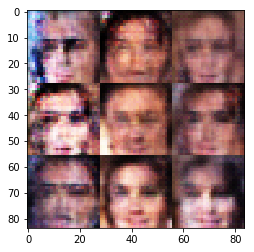

Epoch 0/1... Discriinator Loss: 1.4463 Generator Loss: 0.4258
Epoch 0/1... Discriinator Loss: 1.3916 Generator Loss: 2.2018
Epoch 0/1... Discriinator Loss: 0.8937 Generator Loss: 1.6485
Epoch 0/1... Discriinator Loss: 0.8827 Generator Loss: 1.4855
Epoch 0/1... Discriinator Loss: 0.9630 Generator Loss: 1.2068
Epoch 0/1... Discriinator Loss: 1.4726 Generator Loss: 0.4049
Epoch 0/1... Discriinator Loss: 1.0165 Generator Loss: 0.9666
Epoch 0/1... Discriinator Loss: 1.1998 Generator Loss: 0.6109
Epoch 0/1... Discriinator Loss: 1.1410 Generator Loss: 0.7525
Epoch 0/1... Discriinator Loss: 0.8605 Generator Loss: 0.9962


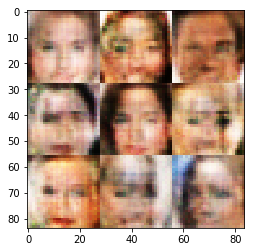

Epoch 0/1... Discriinator Loss: 0.9905 Generator Loss: 2.0702
Epoch 0/1... Discriinator Loss: 1.4886 Generator Loss: 2.0381
Epoch 0/1... Discriinator Loss: 0.9825 Generator Loss: 0.7095
Epoch 0/1... Discriinator Loss: 0.7235 Generator Loss: 1.5343
Epoch 0/1... Discriinator Loss: 1.2155 Generator Loss: 1.0262
Epoch 0/1... Discriinator Loss: 1.9666 Generator Loss: 0.2967
Epoch 0/1... Discriinator Loss: 0.9686 Generator Loss: 1.3776
Epoch 0/1... Discriinator Loss: 0.9019 Generator Loss: 1.5846
Epoch 0/1... Discriinator Loss: 1.1929 Generator Loss: 1.4762
Epoch 0/1... Discriinator Loss: 0.9617 Generator Loss: 1.2327


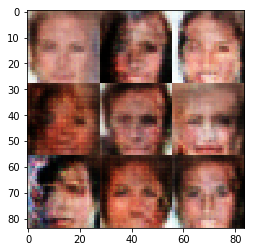

Epoch 0/1... Discriinator Loss: 1.0146 Generator Loss: 1.4085
Epoch 0/1... Discriinator Loss: 0.7192 Generator Loss: 1.0375
Epoch 0/1... Discriinator Loss: 0.5060 Generator Loss: 2.2709
Epoch 0/1... Discriinator Loss: 0.8227 Generator Loss: 2.0122
Epoch 0/1... Discriinator Loss: 1.5101 Generator Loss: 2.2612
Epoch 0/1... Discriinator Loss: 0.8190 Generator Loss: 1.4497
Epoch 0/1... Discriinator Loss: 1.0340 Generator Loss: 0.7557
Epoch 0/1... Discriinator Loss: 1.0451 Generator Loss: 1.8939
Epoch 0/1... Discriinator Loss: 1.7009 Generator Loss: 0.3587
Epoch 0/1... Discriinator Loss: 1.0338 Generator Loss: 1.4154


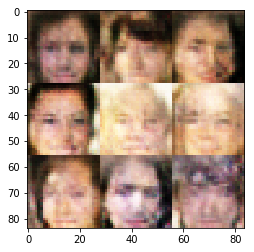

Epoch 0/1... Discriinator Loss: 0.9850 Generator Loss: 1.9962
Epoch 0/1... Discriinator Loss: 0.8702 Generator Loss: 0.8304
Epoch 0/1... Discriinator Loss: 0.8940 Generator Loss: 0.8556
Epoch 0/1... Discriinator Loss: 1.0280 Generator Loss: 0.7734
Epoch 0/1... Discriinator Loss: 0.9703 Generator Loss: 0.6820
Epoch 0/1... Discriinator Loss: 0.7560 Generator Loss: 1.2102
Epoch 0/1... Discriinator Loss: 1.0082 Generator Loss: 0.7607
Epoch 0/1... Discriinator Loss: 1.2701 Generator Loss: 0.7372
Epoch 0/1... Discriinator Loss: 1.1355 Generator Loss: 2.4069
Epoch 0/1... Discriinator Loss: 0.8572 Generator Loss: 1.0117


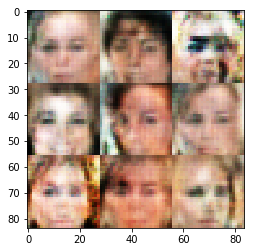

Epoch 0/1... Discriinator Loss: 1.2407 Generator Loss: 2.3930
Epoch 0/1... Discriinator Loss: 1.0771 Generator Loss: 1.0393
Epoch 0/1... Discriinator Loss: 1.1596 Generator Loss: 0.7941
Epoch 0/1... Discriinator Loss: 1.7639 Generator Loss: 0.2625
Epoch 0/1... Discriinator Loss: 0.6823 Generator Loss: 2.6393
Epoch 0/1... Discriinator Loss: 1.0840 Generator Loss: 0.8808
Epoch 0/1... Discriinator Loss: 0.7718 Generator Loss: 1.5317
Epoch 0/1... Discriinator Loss: 0.7957 Generator Loss: 1.4773
Epoch 0/1... Discriinator Loss: 0.8745 Generator Loss: 1.0937
Epoch 0/1... Discriinator Loss: 1.3383 Generator Loss: 1.8987


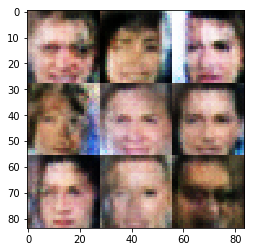

Epoch 0/1... Discriinator Loss: 1.4640 Generator Loss: 0.4508
Epoch 0/1... Discriinator Loss: 1.0998 Generator Loss: 1.1762
Epoch 0/1... Discriinator Loss: 0.9545 Generator Loss: 1.7991
Epoch 0/1... Discriinator Loss: 0.9498 Generator Loss: 1.8517
Epoch 0/1... Discriinator Loss: 1.3644 Generator Loss: 0.6994
Epoch 0/1... Discriinator Loss: 1.4517 Generator Loss: 0.5167
Epoch 0/1... Discriinator Loss: 1.3191 Generator Loss: 0.5036
Epoch 0/1... Discriinator Loss: 1.1738 Generator Loss: 1.6129
Epoch 0/1... Discriinator Loss: 0.8068 Generator Loss: 1.4182
Epoch 0/1... Discriinator Loss: 1.3034 Generator Loss: 0.8835


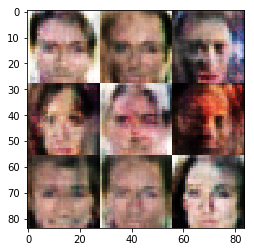

Epoch 0/1... Discriinator Loss: 0.8927 Generator Loss: 0.7435
Epoch 0/1... Discriinator Loss: 1.2564 Generator Loss: 1.7734
Epoch 0/1... Discriinator Loss: 1.0288 Generator Loss: 0.6325
Epoch 0/1... Discriinator Loss: 1.0809 Generator Loss: 1.9932
Epoch 0/1... Discriinator Loss: 1.7281 Generator Loss: 0.3371
Epoch 0/1... Discriinator Loss: 1.2359 Generator Loss: 0.5149
Epoch 0/1... Discriinator Loss: 1.2284 Generator Loss: 0.9440
Epoch 0/1... Discriinator Loss: 1.7693 Generator Loss: 0.2767
Epoch 0/1... Discriinator Loss: 1.2136 Generator Loss: 0.8223
Epoch 0/1... Discriinator Loss: 1.1701 Generator Loss: 0.5632


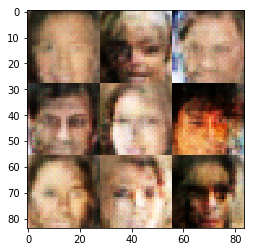

Epoch 0/1... Discriinator Loss: 0.9145 Generator Loss: 0.9602
Epoch 0/1... Discriinator Loss: 1.2339 Generator Loss: 2.5338
Epoch 0/1... Discriinator Loss: 1.0253 Generator Loss: 1.0940
Epoch 0/1... Discriinator Loss: 0.9483 Generator Loss: 0.8514
Epoch 0/1... Discriinator Loss: 1.3428 Generator Loss: 0.4366
Epoch 0/1... Discriinator Loss: 0.8606 Generator Loss: 1.9066
Epoch 0/1... Discriinator Loss: 0.9581 Generator Loss: 0.9159
Epoch 0/1... Discriinator Loss: 0.9529 Generator Loss: 1.5704
Epoch 0/1... Discriinator Loss: 1.3211 Generator Loss: 2.5218
Epoch 0/1... Discriinator Loss: 1.0055 Generator Loss: 0.6291


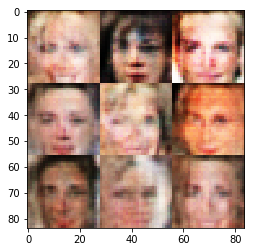

Epoch 0/1... Discriinator Loss: 1.5876 Generator Loss: 1.7902
Epoch 0/1... Discriinator Loss: 1.4940 Generator Loss: 0.4142
Epoch 0/1... Discriinator Loss: 1.2462 Generator Loss: 2.0025
Epoch 0/1... Discriinator Loss: 1.2283 Generator Loss: 1.5884
Epoch 0/1... Discriinator Loss: 2.0236 Generator Loss: 2.9542
Epoch 0/1... Discriinator Loss: 1.1177 Generator Loss: 1.4965
Epoch 0/1... Discriinator Loss: 0.5268 Generator Loss: 1.4629
Epoch 0/1... Discriinator Loss: 2.1224 Generator Loss: 1.8304
Epoch 0/1... Discriinator Loss: 1.4953 Generator Loss: 2.1612
Epoch 0/1... Discriinator Loss: 1.0206 Generator Loss: 1.1785


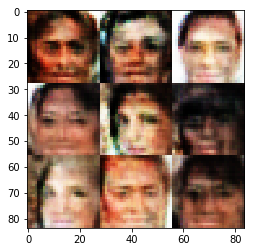

Epoch 0/1... Discriinator Loss: 1.0634 Generator Loss: 0.6580
Epoch 0/1... Discriinator Loss: 1.0546 Generator Loss: 0.5728
Epoch 0/1... Discriinator Loss: 0.7444 Generator Loss: 0.9651
Epoch 0/1... Discriinator Loss: 1.2224 Generator Loss: 2.2765
Epoch 0/1... Discriinator Loss: 1.5341 Generator Loss: 0.4804
Epoch 0/1... Discriinator Loss: 1.1529 Generator Loss: 0.9398
Epoch 0/1... Discriinator Loss: 1.0329 Generator Loss: 0.6921
Epoch 0/1... Discriinator Loss: 1.2143 Generator Loss: 1.4369
Epoch 0/1... Discriinator Loss: 1.5543 Generator Loss: 0.3784
Epoch 0/1... Discriinator Loss: 1.0693 Generator Loss: 0.7073


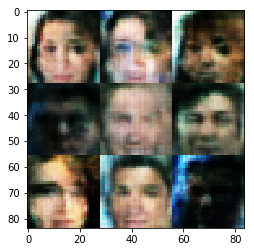

Epoch 0/1... Discriinator Loss: 1.1576 Generator Loss: 0.5451
Epoch 0/1... Discriinator Loss: 0.9393 Generator Loss: 0.9081
Epoch 0/1... Discriinator Loss: 0.9565 Generator Loss: 0.8052
Epoch 0/1... Discriinator Loss: 1.0244 Generator Loss: 1.0931
Epoch 0/1... Discriinator Loss: 0.9840 Generator Loss: 1.2591
Epoch 0/1... Discriinator Loss: 0.8391 Generator Loss: 1.1787


In [15]:
batch_size = 64
z_dim = 100
learning_rate = 0.004
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.